### Make required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from sklearn.model_selection import train_test_split
from interpret import show
from interpret import data
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

warnings.filterwarnings("ignore")
cos_target = 'COS_cgo'

### Load dataframe and separate feature and target sets

In [2]:
df = pd.read_pickle('COS_Seesaw_dataframe.pkl')
# print(df)
columns = list(df.columns)
if cos_target in columns:
    columns.remove(cos_target)
else:
    print('Error, target column not in dataframe')
    quit()
    
x = df[columns]
y = df[cos_target]

### Make test train split, random seed is to ensure consistent results on multiple runs
### change  seed value to get different split

In [3]:
seed = 5
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

# set up for predicted vs actual plot
# sorting the test set should not matter since we are not using it to train
X_test = X_test.sort_index()
y_test = y_test.sort_index()

test_time = X_test['time']
# divide test set by year and save for later
start = X_test['time'].min().year
end = X_test['time'].max().year
test_by_year = []

for year in range(start, (end + 1)):
    year_X = X_test[X_test['time'].dt.year == year]
    year_y = y_test.where(y_test.index.isin(year_X.index))
    
    year_y.dropna(inplace=True)
    year_time = year_X['time']
    year_X.drop(axis=1, labels='time', inplace=True)
    year_data = (year, year_time, year_X, year_y)
    test_by_year.append(year_data)

# print(test_by_year)

X_test.drop(axis=1, labels='time', inplace=True)

#drop time in X_train
X_train.drop(axis=1, labels='time', inplace=True)

### Show Marginal

In [4]:
marginal = data.Marginal()
marginal_explanation = marginal.explain_data(X_train, y_train)
show(marginal_explanation)

<!-- http://127.0.0.1:7001/140180283984576/ -->

### Train Models

In [5]:
ebm = ExplainableBoostingRegressor(random_state=seed, interactions=3)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['cos_mean-1y', 'SO_sal', 'AO_sal',
                                            'NEP_sal', 'NWP_sal', 'EQNEP_sal',
                                            'EQNWP_sal', 'EQSEP_sal',
                                            'EQSWP_sal', 'SEP_sal', 'SWP_sal',
                                            'NA_sal', 'EQNA_sal', 'EQSA_sal',
                                            'SA_sal', 'NI_sal', 'EQI_sal',
                                            'SI_sal', 'SO_mld', 'AO_mld',
                                            'NEP_mld', 'NWP_mld', 'EQNEP_mld',
                                            'EQNWP_mld', 'EQSEP_mld',
                                            'EQSWP_mld', 'SEP_mld', 'SWP_mld',
                                            'NA_mld', 'EQ...
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                 

### What model learned

In [6]:
ebm_global = ebm.explain_global(name='EBM')

### Explanation of individul prediction

In [7]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')

### Evaluate performance

In [8]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')

### Everything at once

In [9]:
show([marginal_explanation, ebm_global, ebm_perf, ebm_local])

<!-- http://127.0.0.1:7001/140179313027200/ -->
 Open in new window

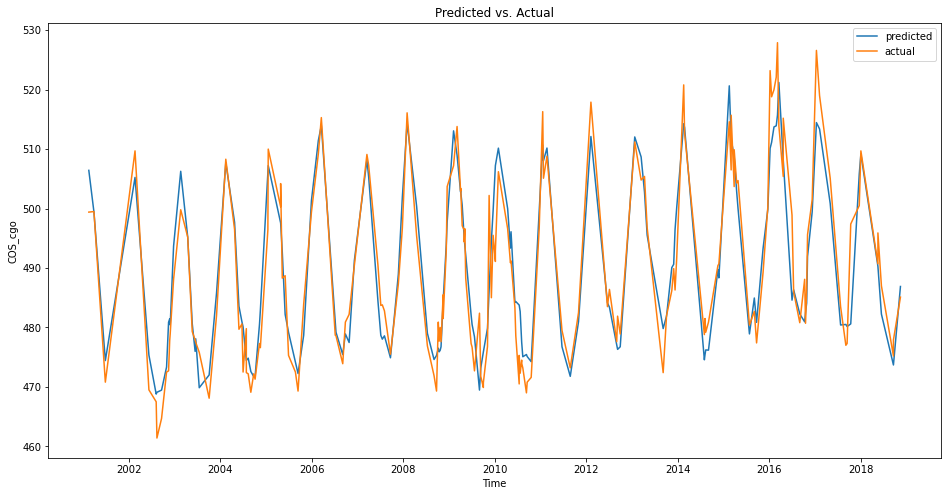

In [10]:
predicted = ebm.predict(X_test)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test_time, predicted, '-',  label='predicted')
ax.plot(test_time, y_test, '-', label='actual')
ax.set_title("Predicted vs. Actual")
ax.set_xlabel('Time')
ax.set_ylabel(cos_target)
plt.legend()
plt.show()
fig.savefig('predictedVsActualOverTime.png')

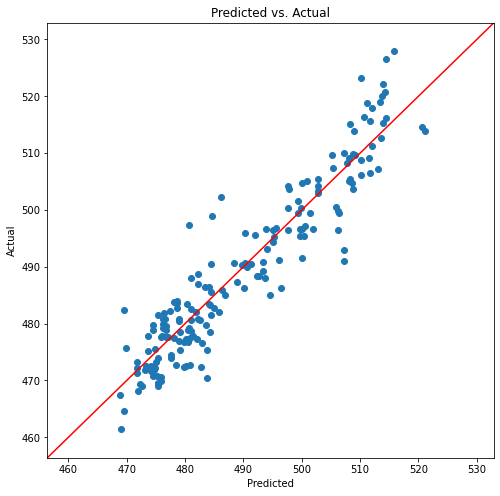

In [11]:
axis_min = min(y_test.min(), min(predicted)) - 5 # pad by 5
axis_max = max(y_test.max(), max(predicted)) + 5 # pad by 5
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(predicted, y_test)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Predicted vs. Actual')
ax.plot([0,1],[0,1], color='red', transform=ax.transAxes)
ax.set_xlim([axis_min, axis_max])
ax.set_ylim([axis_min, axis_max])
plt.show()


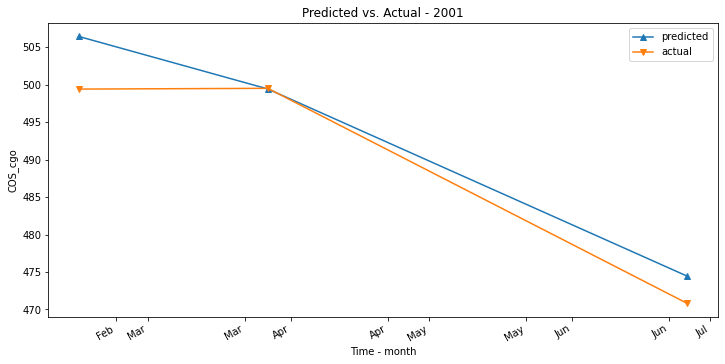

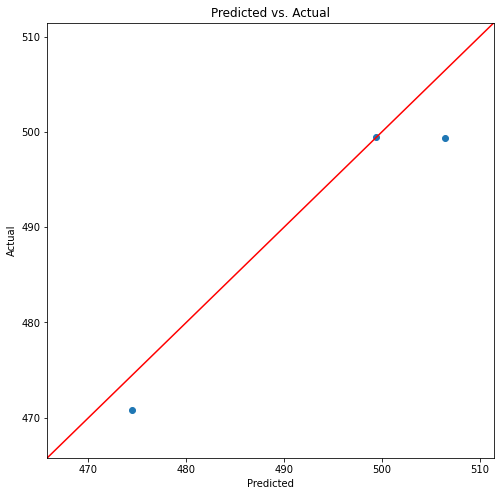

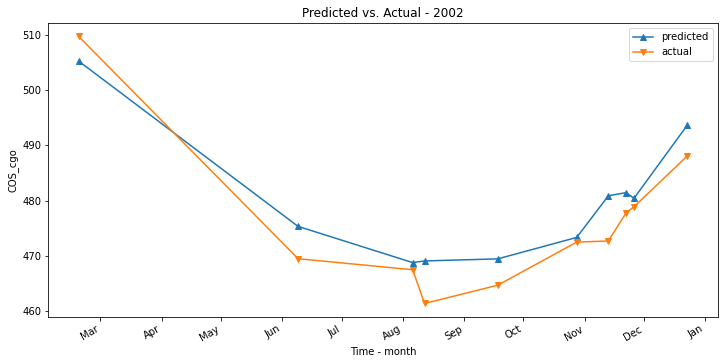

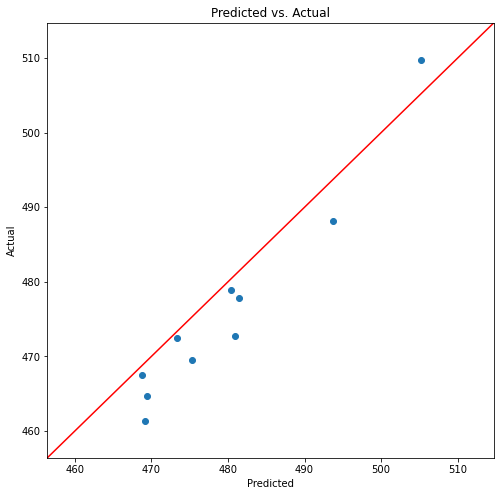

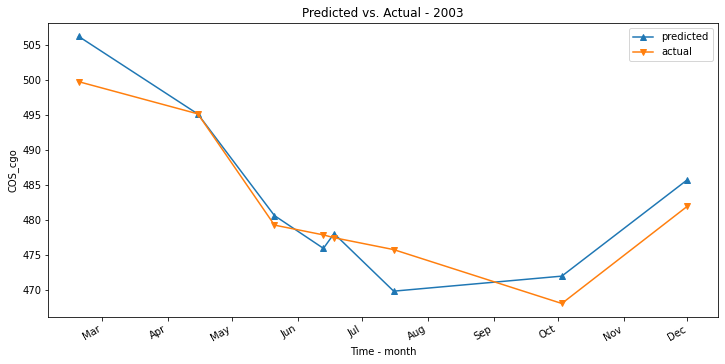

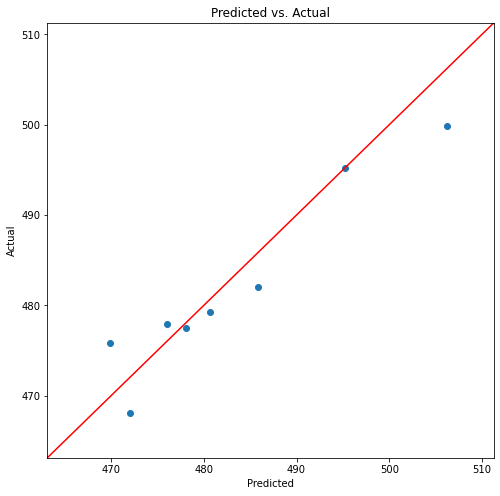

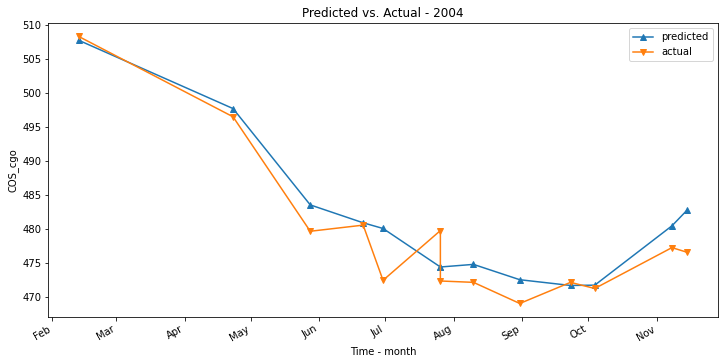

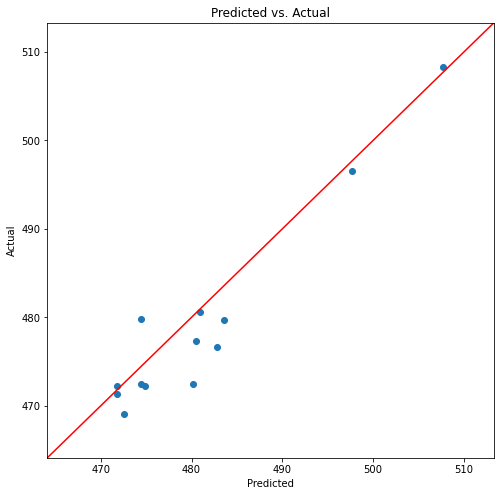

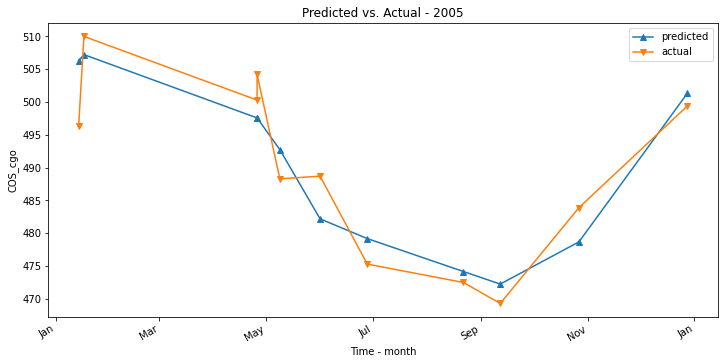

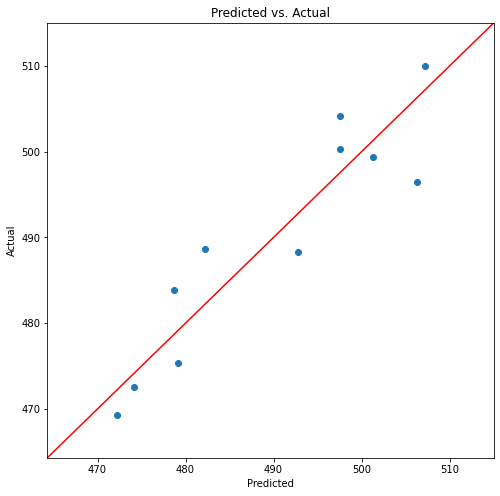

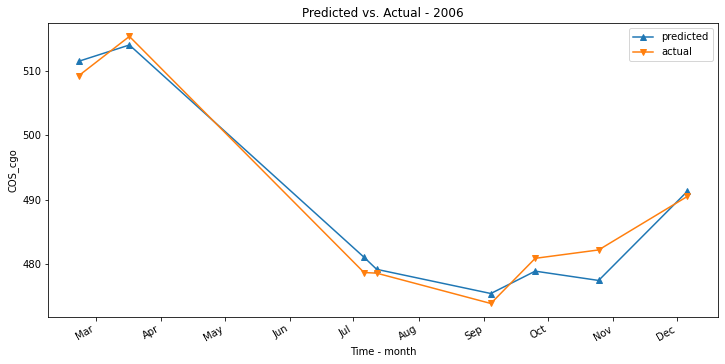

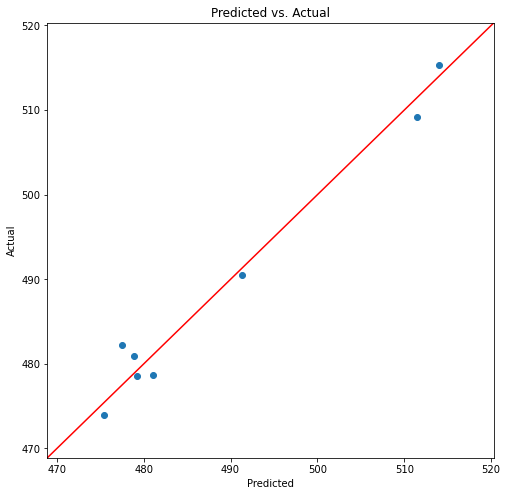

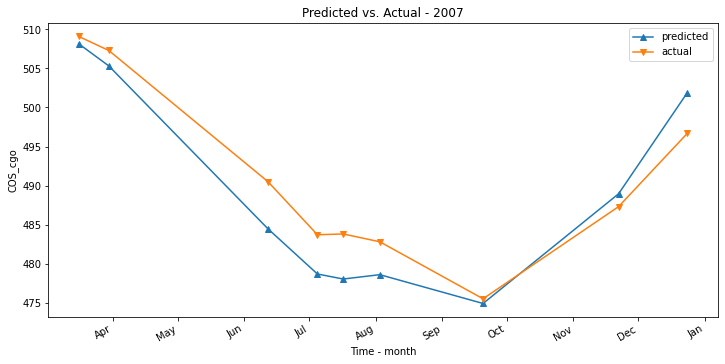

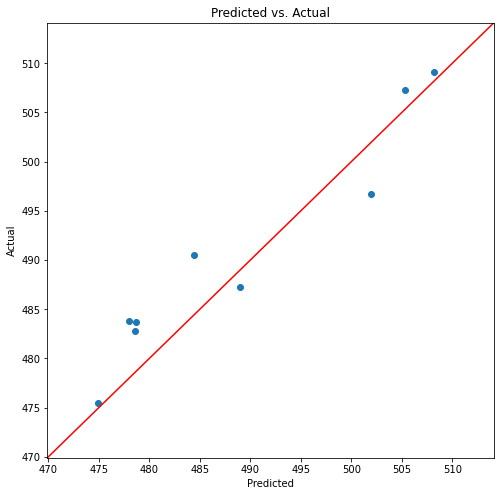

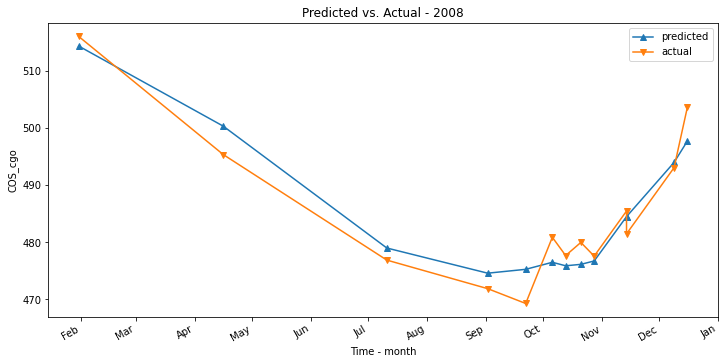

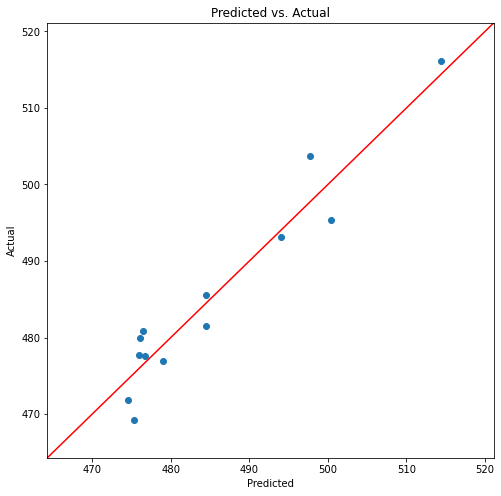

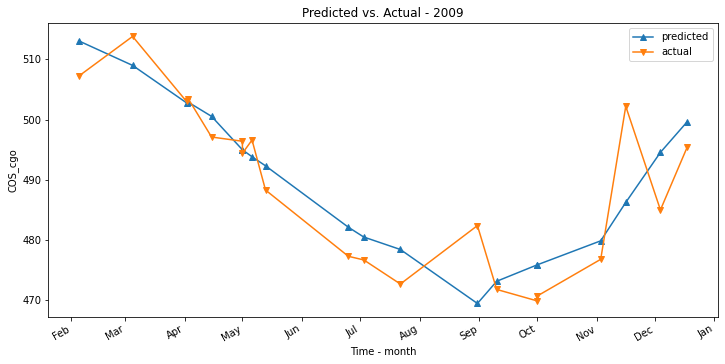

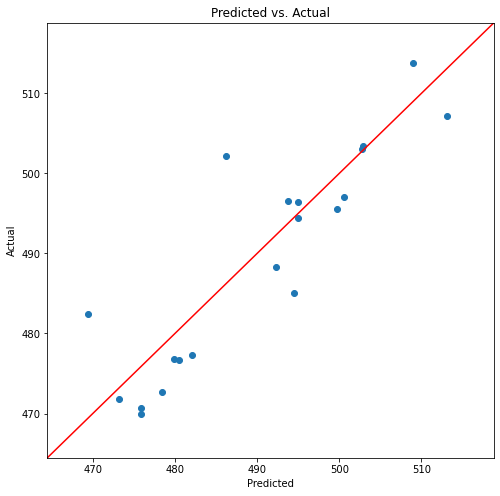

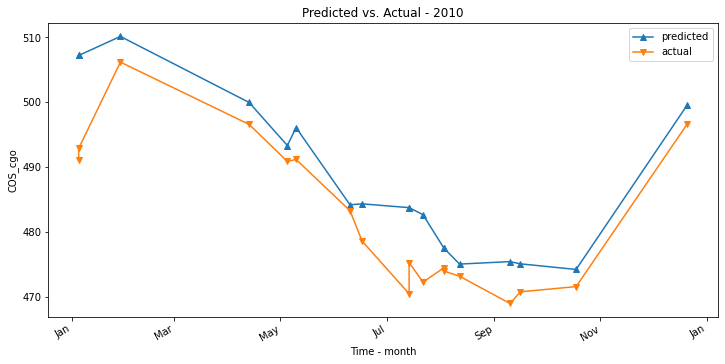

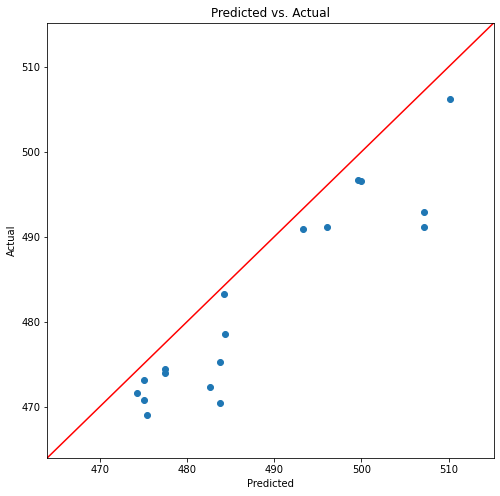

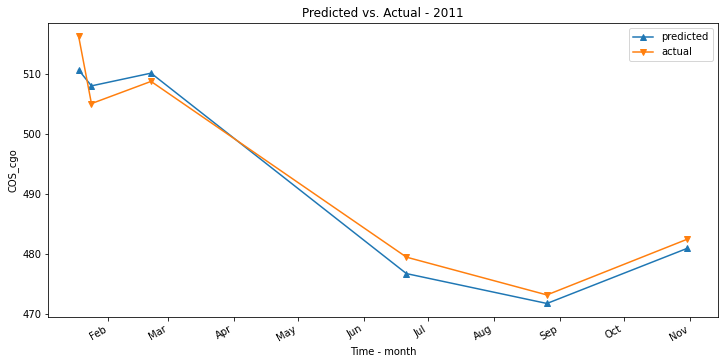

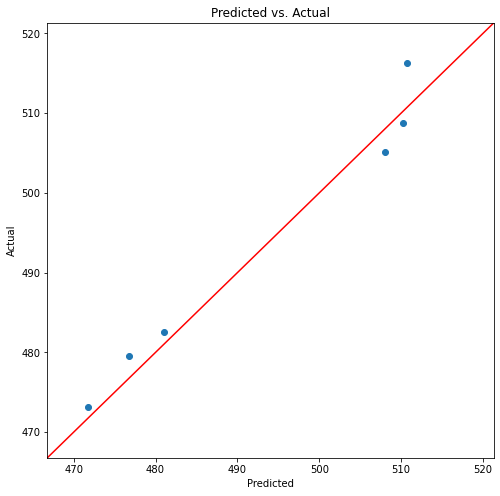

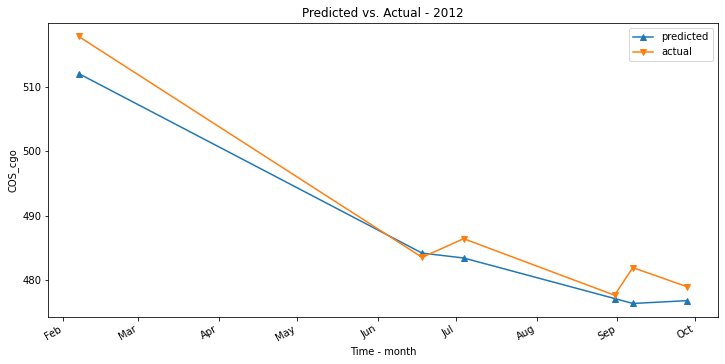

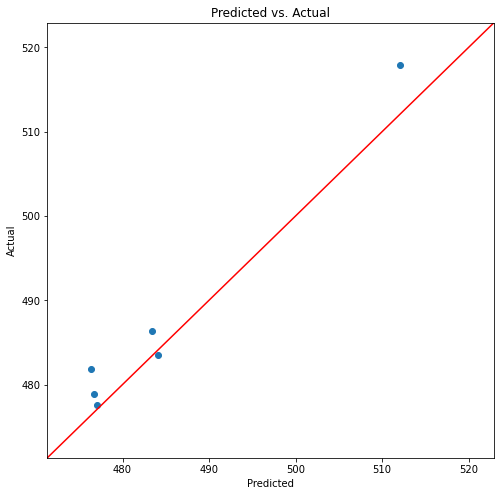

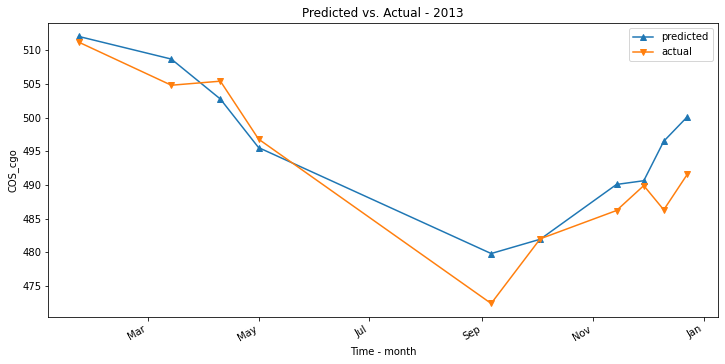

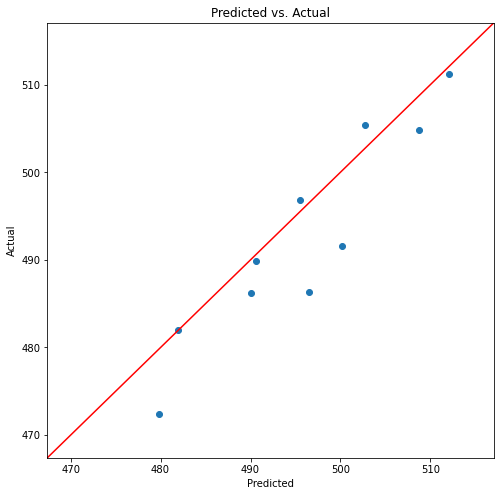

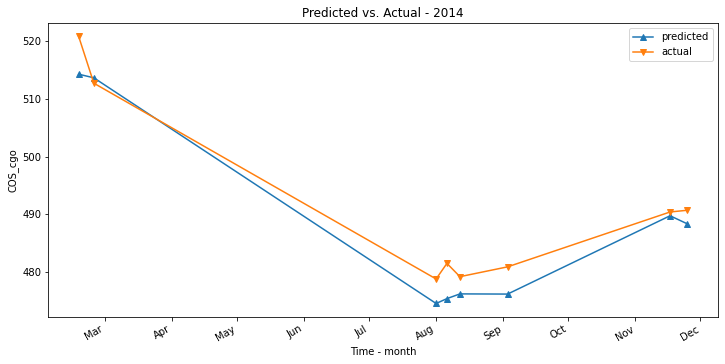

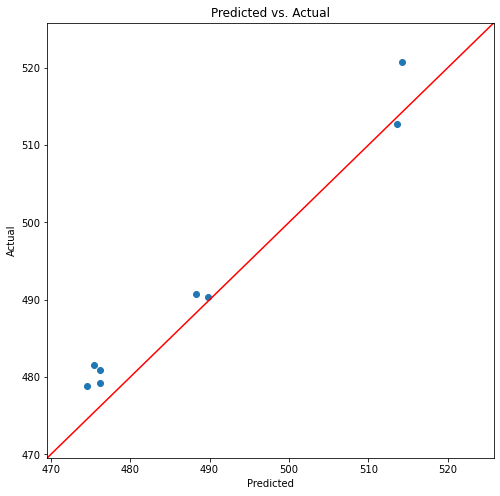

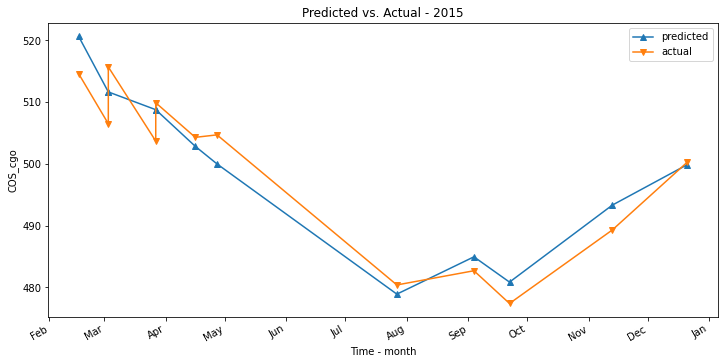

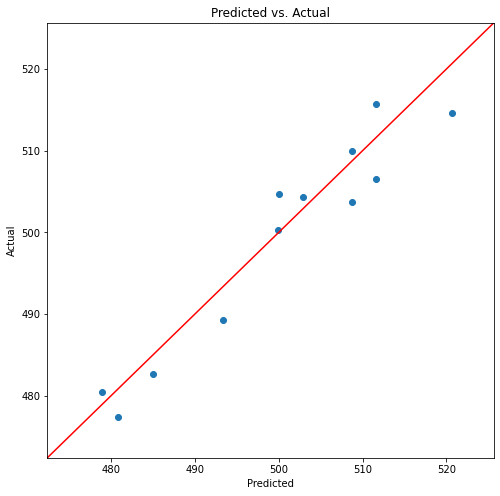

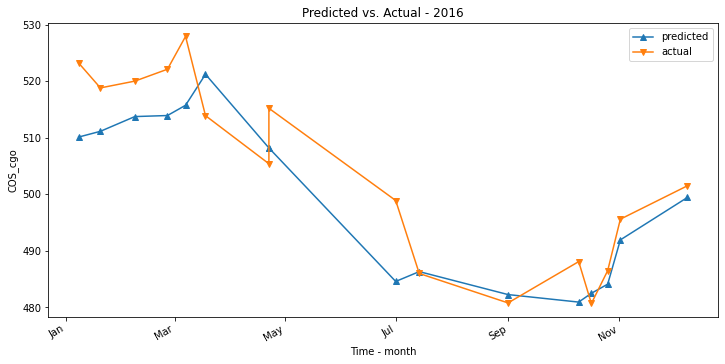

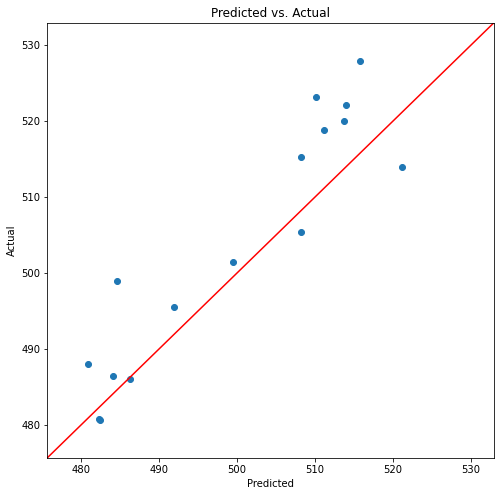

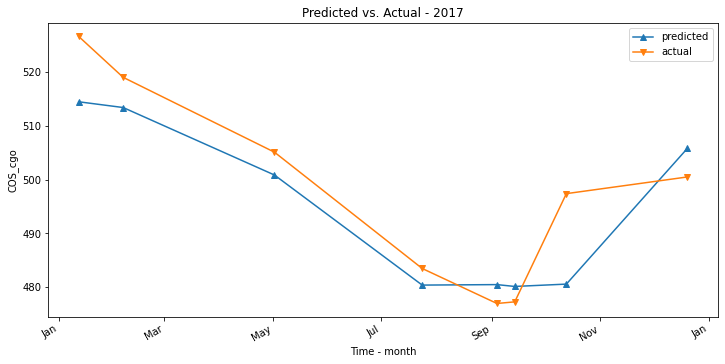

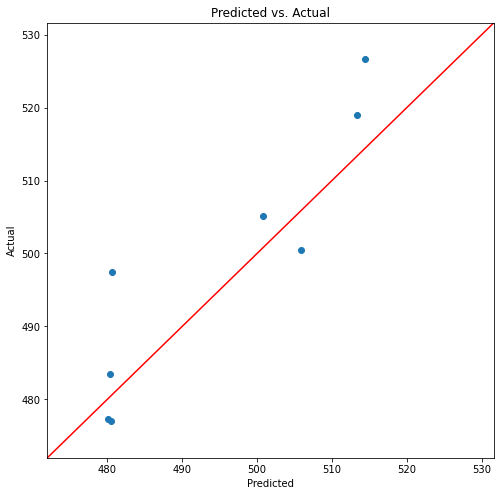

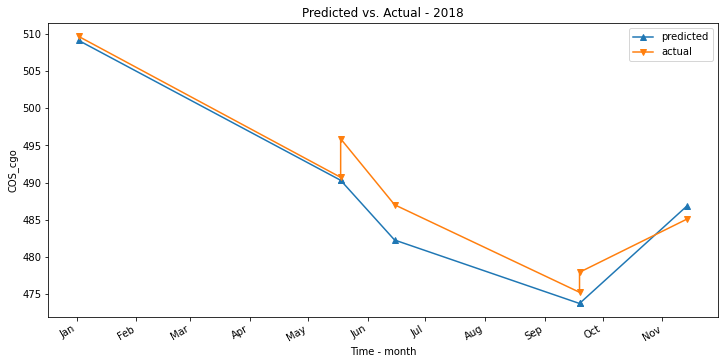

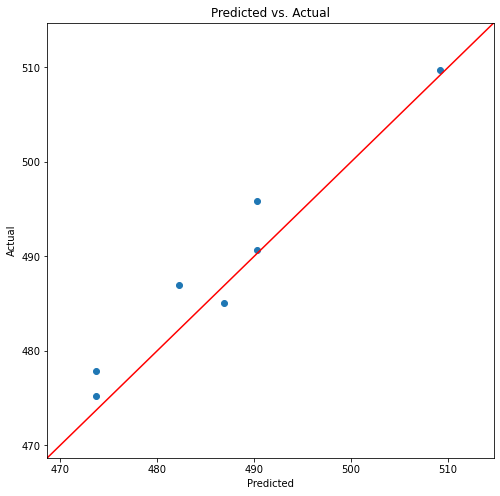

In [12]:
import math
rmse_dict = {'year' : [], 'rmse': []}
for year in test_by_year:
    predicted = ebm.predict(year[2])
    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(year[1], predicted, '-^', label='predicted')
    ax.plot(year[1], year[3], '-v',label='actual')
    ax.set_title('Predicted vs. Actual - ' + str(year[0]))
    ax.set_xlabel('Time - month')
    ax.set_ylabel(cos_target)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.legend()
    plt.show()
    
    axis_min = min(year[3].min(), min(predicted)) - 5 # pad by 5
    axis_max = max(year[3].max(), max(predicted)) + 5 # pad by 5
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(predicted, year[3])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Predicted vs. Actual')
    ax.plot([0,1],[0,1], color='red', transform=ax.transAxes)
    ax.set_xlim([axis_min, axis_max])
    ax.set_ylim([axis_min, axis_max])
    plt.show()
    
    mse = np.square(np.subtract(predicted, year[3])).mean()
    rmse = math.sqrt(mse)
    rmse_dict['year'].append(str(year[0]))
    rmse_dict['rmse'].append(rmse)
    

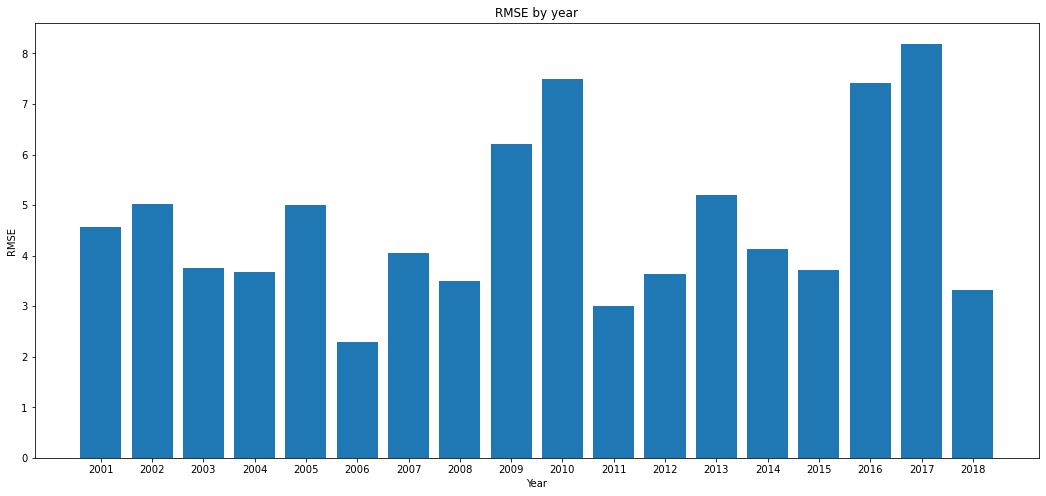

In [13]:
fig, ax = plt.subplots(figsize=(18,8))
ax.bar(rmse_dict['year'], rmse_dict['rmse'])
ax.set_xlabel('Year')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by year')
plt.show()